# NeuroGraphNet

*A graph-based deep learning framework for EEG seizure detection, designed to improve accuracy and interpretability by leveraging Graph Neural Networks (GNNs) to capture spatial and temporal brain dynamics.*

<hr />

This notebook presents **NeuroGraphNet**, a model that applies Graph Neural Networks to EEG data for seizure detection. The primary goal is to **compare the performance and interpretability of graph-based methods versus traditional deep learning approaches**. Through this comparison, we aim to demonstrate the advantages of incorporating brain connectivity information into the learning process.

**Authors**: Luca Di Bello, Guillaume André Bélissent, Abdessalem Ben Ali, Beatriz Izquierdo González

In [6]:
%load_ext autoreload
%autoreload 1
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader as GeoDataLoader
from src.utils.seeder import seed_everything

# set seaborn theme
sns.set_theme()

# create useful constants
RANDOM_SEED = 42
IS_SCITAS = True # set to True if running on SCITAS cluster
LOCAL_DATA_ROOT = Path("./data")
DATA_ROOT = Path("/home/ogut/data") if IS_SCITAS else LOCAL_DATA_ROOT
CHECKPOINT_ROOT = Path("./.checkpoints")
SUBMISSION_ROOT = Path("./.submissions")

# create directories if they do not exist
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
SUBMISSION_ROOT.mkdir(parents=True, exist_ok=True)

# set dataset root
seed_everything(RANDOM_SEED)

# setup torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Load clips

In [7]:
%aimport src.utils.signal
from src.utils.signal import time_filtering, normalize
%aimport src.utils.dataset
from src.utils.dataset import ensure_eeg_multiindex

start = time.time()
print("⏳ Loading EEG segment tables…")
clips_tr = pd.read_parquet(DATA_ROOT / "train" / "segments.parquet").dropna()
clips_te = pd.read_parquet(DATA_ROOT / "test" / "segments.parquet").dropna()

# load clips with label
clips_tr = ensure_eeg_multiindex(clips_tr, id_col_name='id')
clips_te = ensure_eeg_multiindex(clips_te, id_col_name='id')

print(f"✔️ Loaded: {len(clips_tr)} train rows, {len(clips_te)} test rows "
      f"(took {time.time()-start:.1f}s)")
# NOTE: Merge clips for sanity checks
clips = pd.concat([clips_tr, clips_te]).reset_index()

⏳ Loading EEG segment tables…
✔️ Loaded: 12993 train rows, 3614 test rows (took 0.0s)


## Load features

In [8]:
# print feature shapes
X_train = np.load(LOCAL_DATA_ROOT / "extracted_features" / "X_train.npy", allow_pickle=True)
X_test = np.load(LOCAL_DATA_ROOT / "extracted_features" / "X_test.npy", allow_pickle=True)
y_train = np.load(LOCAL_DATA_ROOT / "labels" / "y_train.npy", allow_pickle=True)
sample_subject_array = np.load(LOCAL_DATA_ROOT / "extracted_features" / "sample_subject_array_train.npy",allow_pickle=True)

# sanity checks to ensure validity of the data
assert X_train.shape[0]  == y_train.shape[0], "Mismatch in number of training samples and labels"
assert X_train.shape[1] == X_test.shape[1], "Mismatch in number of features between train and test sets"
assert clips_tr.shape[0] == y_train.shape[0], "Mismatch in number of training samples and segments"
assert X_train.shape[0] == sample_subject_array.shape[0], "Mismatch in number of training samples and subjects"
assert clips_tr.shape[0] == sample_subject_array.shape[0], "Mismatch in number of training segments and subjects"

print("Train extracted features shape:", X_train.shape)
print("Test extracted features shape:", X_test.shape)

Train extracted features shape: (12993, 228)
Test extracted features shape: (3614, 228)


In [9]:
# ------------------------------- Extracted features -----------------------------------------------#
channels = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']
features = [
    "rms", "linelen", "hj_mob", "hj_cmp", "spec_ent",
    "alpha_pow", "beta_pow", "theta_pow", "gamma_pow",
    "rel_alpha", "rel_theta", "theta_alpha_ratio"
]
n_features = len(features)
n_channels = len(channels)

feature_names = [f"{ch} - {ft}" for ch in channels for ft in features]

## Data splitting and (possible) feature selection

In [10]:
from src.utils.dataset import GraphEEGDataset

LOCAL_DATA_ROOT = Path("./data")

# Initialization for the training dataset
dataset_tr = GraphEEGDataset(
    root=str(LOCAL_DATA_ROOT / 'graph_dataset_train'),
    clips_df=clips_tr,
    signal_folder=str(DATA_ROOT / 'train'),
    extracted_features=X_train,
    use_extracted_features=True,
    edge_strategy='spatial',
    spatial_distance_file=str(LOCAL_DATA_ROOT / 'distances_3d.csv'),
    force_reprocess=True,
    prefetch_data=False,
)

# Initialization for the test dataset
dataset_te = GraphEEGDataset(
    root=str(LOCAL_DATA_ROOT / 'graph_dataset_test'),
    clips_df=clips_te,
    signal_folder=str(DATA_ROOT / 'test'),
    extracted_features=X_test,
    use_extracted_features=True,
    edge_strategy='spatial',
    spatial_distance_file=str(LOCAL_DATA_ROOT / 'distances_3d.csv'),
    force_reprocess=True, # Force reprocess for test dataset
    prefetch_data=False,
)

print(f"Training dataset object created: {dataset_tr}")
print(f"Test dataset object created: {dataset_te}")

# You can then check their lengths or get items:
print(f"Length of training dataset: {len(dataset_tr)}")
if len(dataset_tr) > 0:
    sample_train_data = dataset_tr[0]
    print(f"First training sample: {sample_train_data}")

# print(f"Length of test dataset: {len(dataset_te)}")
if len(dataset_te) > 0:
    sample_test_data = dataset_te[0]
    print(f"First test sample: {sample_test_data}, Label (y): {sample_test_data.y}")

🚀 Initializing GraphEEGDataset at root: data/graph_dataset_train
   - Mode: Using pre-extracted features
   - Edge strategy: spatial
   - Preprocessing: Filtering=True, Rereferencing=True, Normalization=True
   - Detected sampling rate: 250 Hz
   - Clip duration: 12.0s, Segment length: 3000 timesteps
   - Designing filters: Bandpass (0.5, 50.0) Hz, Notch 60.0 Hz
   - Loading spatial distances...
     - Loaded 180 unique spatial distances.
   - Calling PyG Dataset super().__init__()...


Processing...


⚙️ process() called. Target processed directory: data/graph_dataset_train/processed
   - Force reprocess: Deleting existing files in data/graph_dataset_train/processed...
     - Deleted 12993 existing .pt files.
   - Starting processing from pre-extracted features...
   - Total features to process: 12993
     - Processing feature item 1299/12993...
     - Processing feature item 2598/12993...
     - Processing feature item 3897/12993...
     - Processing feature item 5196/12993...
     - Processing feature item 6495/12993...
     - Processing feature item 7794/12993...
     - Processing feature item 9093/12993...
     - Processing feature item 10392/12993...
     - Processing feature item 11691/12993...
     - Processing feature item 12990/12993...
     - Processing feature item 12993/12993...
   ✅ Processed and saved 12993 items from features.
🏁 process() finished.
   - PyG Dataset super().__init__() call complete.
🏁 GraphEEGDataset initialization complete. Found 12993 items.
🚀 Initia

Done!
Processing...


     - Deleted 3614 existing .pt files.
   - Starting processing from pre-extracted features...
   ⚠️ Warning: 'label' column not found in clips_df. Labels will be None for feature processing.
   - Total features to process: 3614
     - Processing feature item 361/3614...
     - Processing feature item 722/3614...
     - Processing feature item 1083/3614...
     - Processing feature item 1444/3614...
     - Processing feature item 1805/3614...
     - Processing feature item 2166/3614...
     - Processing feature item 2527/3614...
     - Processing feature item 2888/3614...
     - Processing feature item 3249/3614...
     - Processing feature item 3610/3614...
     - Processing feature item 3614/3614...
   ✅ Processed and saved 3614 items from features.
🏁 process() finished.
   - PyG Dataset super().__init__() call complete.
🏁 GraphEEGDataset initialization complete. Found 3614 items.
Training dataset object created: GraphEEGDataset(12993)
Test dataset object created: GraphEEGDataset(36

Done!


In [11]:
from torch.utils.data import random_split

TRAIN_RATIO = 0.8
TRAIN_SIZE = int(len(dataset_tr) * TRAIN_RATIO)
VAL_SIZE = len(dataset_tr) - TRAIN_SIZE
# Split the dataset into training and validation sets
dataset_tr, dataset_val = random_split(dataset_tr, [TRAIN_SIZE, VAL_SIZE])
print(f"Train dataset size: {len(dataset_tr)}, Validation dataset size: {len(dataset_val)}")

Train dataset size: 10394, Validation dataset size: 2599


In [28]:
# ——— create data loaders ———
print("⏳ Creating DataLoaders…")
dl_start = time.time()
common_loader_kwargs = dict(
    batch_size=512,
    num_workers=16,
    persistent_workers=True,
    pin_memory=True,
    prefetch_factor=8,
)

# NOTE: shuffle=True for training, False for validation and test in order to
#       maintain the order of the data (important for evaluation)
train_loader = GeoDataLoader(dataset_tr, shuffle=True,  **common_loader_kwargs)
val_loader   = GeoDataLoader(dataset_val, shuffle=False, **common_loader_kwargs)
test_loader  = GeoDataLoader(dataset_te, shuffle=False, **common_loader_kwargs)
print(f"✔️ GeoDataLoaders created (took {time.time()-dl_start:.1f}s):\n"
      f"   • train: {len(train_loader)} batches\n"
      f"   • val:   {len(val_loader)} batches\n"
      f"   • test:  {len(test_loader)} batches")

⏳ Creating DataLoaders…
✔️ GeoDataLoaders created (took 0.0s):
   • train: 21 batches
   • val:   6 batches
   • test:  8 batches


## Traditional approaches (no additional features)

In [25]:
%aimport src.utils.train
from src.utils.train import train_model, evaluate_model
from src.utils.plot import plot_training_loss

### 1. LSTM classifier (baseline)

In [26]:
%aimport src.layers.lstm
from src.layers.lstm import LSTM

LSTM_SAVE_PATH = CHECKPOINT_ROOT / "lstm_best_model.pt"
LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "lstm_submission.csv"

# build model with current parameters
lstm_model = LSTM(input_dim=12,
                hidden_dim=64,
                num_layers=4,
                dropout=0.1)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for this combination.")
    lstm_model = nn.DataParallel(lstm_model)
lstm_model = lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()  # Assuming this remains constant
optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


Using 2 GPUs for this combination.


In [29]:
LSTM_SAVE_PATH = CHECKPOINT_ROOT / "lstm_best_model.pt"
LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "lstm_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
        lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=LSTM_SAVE_PATH,
        num_epochs=300,
        patience=10,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=True,
        use_gnn=False
    )

💪 Starting training from epoch 1 to 300...


Epochs:   6%| | 18/300 [00:15<04:22,  1.07it/s, train_loss=0.4920, val_loss=0.4801, best_val_loss=0.4801, lr=7.50e-05, b

🛑 Early stopping: no 'val_loss' improvement in 10 epochs.

✅ Training complete.
↩️ Loading best model state from .checkpoints/lstm_best_model.pt for return.
   - Loading checkpoint from: .checkpoints/lstm_best_model.pt
   - Detected full checkpoint dictionary.
   - Model state successfully loaded.


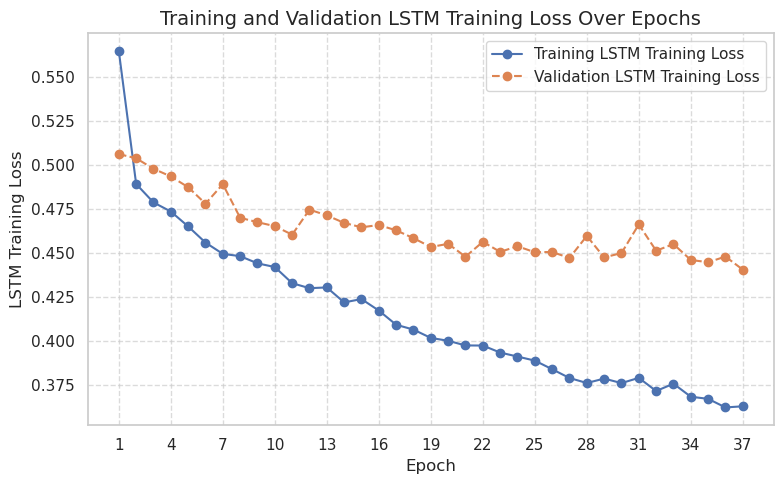

In [ ]:
plot_training_loss(train_history["loss"], val_history["loss"], "LSTM")

### 2. Bidirectional LSTM with early stopping

In [ ]:
from src.layers.lstm import BiLSTM

# Create model and fit it
bi_lstm_model = BiLSTM(input_dim=19, hidden_dim=64, num_layers=3, dropout=0.2)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    bi_lstm_model = nn.DataParallel(bi_lstm_model)   # splits batches across all GPUs
bi_lstm_model = bi_lstm_model.to(device)         # CPU or GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(bi_lstm_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

In [ ]:
BI_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "bi_lstm_best_model.pt"
BI_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "bi_lstm_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
        bi_lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=BI_LSTM_SAVE_PATH,
        num_epochs=300,
        patience=10,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=True,
        use_gnn=False
    )

   Overwrite enabled: Removed existing checkpoint at .checkpoints/bi_lstm_best_model.pt
💪 Starting training from epoch 1 to 300...


Epochs:  13%|▏| 38/300 [11:21<1:20:27, 18.43s/it, train_loss=0.1641, val_loss=0.3372, best_val_loss=0.3037, lr=5.00e-04,

🛑 Early stopping: no 'val_loss' improvement in 10 epochs.

✅ Training complete.
↩️ Loading best model state from .checkpoints/bi_lstm_best_model.pt for return.
   - Loading checkpoint from: .checkpoints/bi_lstm_best_model.pt
   - Detected full checkpoint dictionary.
   - Model state successfully loaded.


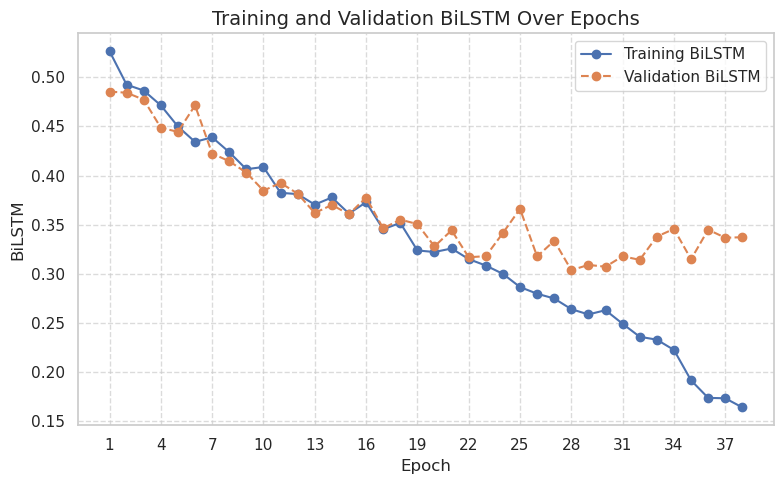

In [ ]:
plot_training_loss(train_history["loss"], val_history["loss"], "BiLSTM")

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    bi_lstm_model, test_loader, device,
    save_path=BI_LSTM_SAVE_PATH,
    submission_path=BI_LSTM_SUBMISSION_PATH,
)

TypeError: evaluate_model() got an unexpected keyword argument 'save_path'

### 3. LSTM with Attention and early stopping

In [ ]:
from src.layers.lstm import LSTMAttention

# Create model and fit it
attention_lstm_model = LSTMAttention(input_dim=19, hidden_dim=64, num_layers=3, dropout=0.2)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    attention_lstm_model = nn.DataParallel(attention_lstm_model)   # splits batches across all GPUs
attention_lstm_model = attention_lstm_model.to(device)         # CPU or GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(
    attention_lstm_model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min',
    patience=5,
    factor=0.5
)

In [ ]:
ATTENTION_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "attention_lstm_best_model.pt"
ATTENTION_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "attention_lstm_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
        attention_lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=ATTENTION_LSTM_SAVE_PATH,
        num_epochs=300,
        patience=10,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=False,
        use_gnn=False
    )

💪 Starting training from epoch 1 to 300...


Epochs:   0%|▎                                                                                  | 1/300 [00:00<?, ?it/s]


RuntimeError: Pin memory thread exited unexpectedly

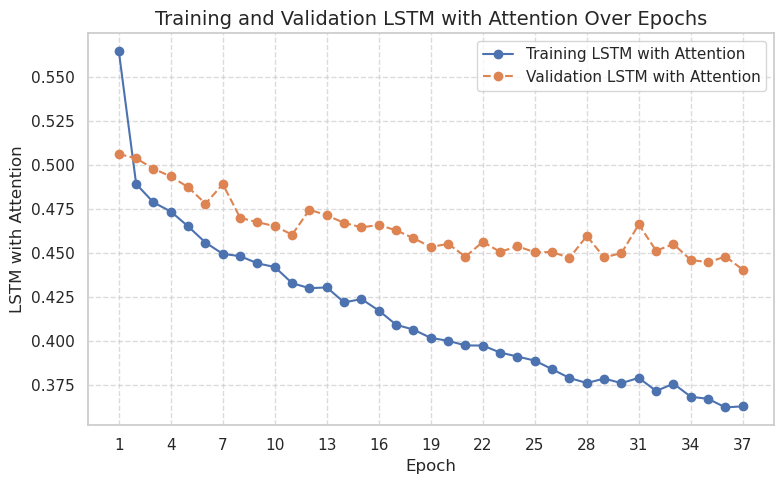

In [ ]:
plot_training_loss(train_history["loss"], val_history["loss"], "LSTM with Attention")

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    attention_lstm_model, test_loader, device,
    checkpoint_path=ATTENTION_LSTM_SAVE_PATH,
    submission_path=ATTENTION_LSTM_SUBMISSION_PATH,
)

⚙️ Evaluating model. Loading model from: .checkpoints/attention_lstm_best_model.pt
❌ Error: Checkpoint file not found at .checkpoints/attention_lstm_best_model.pt. Cannot evaluate.


""


### 4. EEG CNN

In [ ]:
%aimport src.layers.cnn
from src.layers.cnn import EEG_CNN

eeg_cnn_model = EEG_CNN(
    input_channels=19,
    dropout=0.3
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    eeg_cnn_model = nn.DataParallel(eeg_cnn_model)
eeg_cnn_model = eeg_cnn_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(eeg_cnn_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=5,
    factor=0.5
)

In [ ]:
EEG_CNN_SAVE_PATH = CHECKPOINT_ROOT / "eeg_cnn_best_model.pt"
EEG_CNN_SUBMISSION_PATH = SUBMISSION_ROOT / "eeg_cnn_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
        eeg_cnn_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=EEG_CNN_SUBMISSION_PATH,
        num_epochs=300,
        patience=10,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=True,
        use_gnn=False
    )

   Overwrite enabled: Removed existing checkpoint at .submissions/eeg_cnn_submission.csv
💪 Starting training from epoch 1 to 300...


Epochs:   0%|▎                                                                                  | 1/300 [00:00<?, ?it/s]/home/ldibello/venvs/neuro/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epochs:   4%| | 11/300 [05:53<2:50:29, 35.40s/it, train_loss=0.0932, val_loss=0.4008, best_val_loss=0.2869, lr=5.00e-04,

🛑 Early stopping: no 'val_loss' improvement in 10 epochs.

✅ Training complete.
↩️ Loading best model state from .submissions/eeg_cnn_submission.csv for return.
   - Loading checkpoint from: .submissions/eeg_cnn_submission.csv
   - Detected full checkpoint dictionary.
   - Model state successfully loaded.


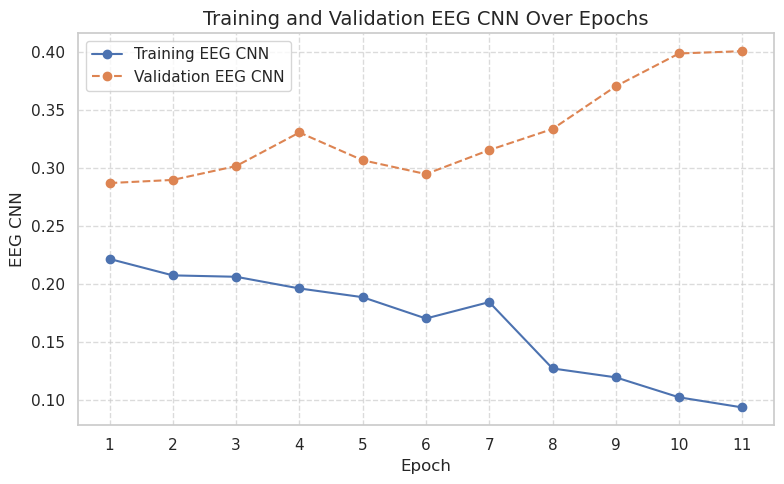

In [ ]:
plot_training_loss(train_history["loss"], val_history["loss"], "EEG CNN")

In [ ]:
%aimport src.utils.train
from src.utils.train import evaluate_model

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    eeg_cnn_model, test_loader, device,
    checkpoint_path=EEG_CNN_SAVE_PATH,
    submission_path=EEG_CNN_SUBMISSION_PATH
)

⚙️ Evaluating model. Loading model from: .checkpoints/eeg_cnn_best_model.pt
   - Loading checkpoint from: .checkpoints/eeg_cnn_best_model.pt
   - Warning: Loaded a raw state_dict. Optimizer state and training history not in this file.
❌ Error loading model checkpoint for evaluation: Error(s) in loading state_dict for EEG_CNN:
	Missing key(s) in state_dict: "stem.0.weight", "stem.0.bias", "stem.1.weight", "stem.1.bias", "layer0_conv.0.weight", "layer0_conv.0.bias", "layer0_conv.1.weight", "layer0_conv.1.bias", "layer1_conv.0.weight", "layer1_conv.0.bias", "layer1_conv.1.weight", "layer1_conv.1.bias", "layer2_conv_res.0.weight", "layer2_conv_res.0.bias", "layer2_conv_res.1.weight", "layer2_conv_res.1.bias", "layer3_conv.0.weight", "layer3_conv.0.bias", "layer3_conv.1.weight", "layer3_conv.1.bias", "layer4_conv_res.0.weight", "layer4_conv_res.0.bias", "layer4_conv_res.1.weight", "layer4_conv_res.1.bias", "attn_pool.q_param", "attn_pool.kv_projection.weight", "fc.weight", "fc.bias". 
	Unex

""


### 5. EEG CNN LSTM

In [ ]:
%aimport src.layers.cnn
from src.layers.cnn import EEG_CNN_LSTM

cnn_lstm_model = EEG_CNN_LSTM(
    input_channels=19,
    cnn_output_channels=128,
    lstm_hidden_dim=128, 
    fc_dropout=0.3,
    lstm_dropout=0.3,
    num_classes=1,
    bidirectional_lstm=False # unidirectional
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    cnn_lstm_model = nn.DataParallel(cnn_lstm_model)
cnn_lstm_model = cnn_lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=5,
    factor=0.5
)

In [ ]:
CNN_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "cnn_lstm_best_model.pt"
CNN_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "cnn_lstm_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
        cnn_lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=CNN_LSTM_SAVE_PATH,
        num_epochs=300,
        patience=30,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=True,
        use_gnn=False
    )

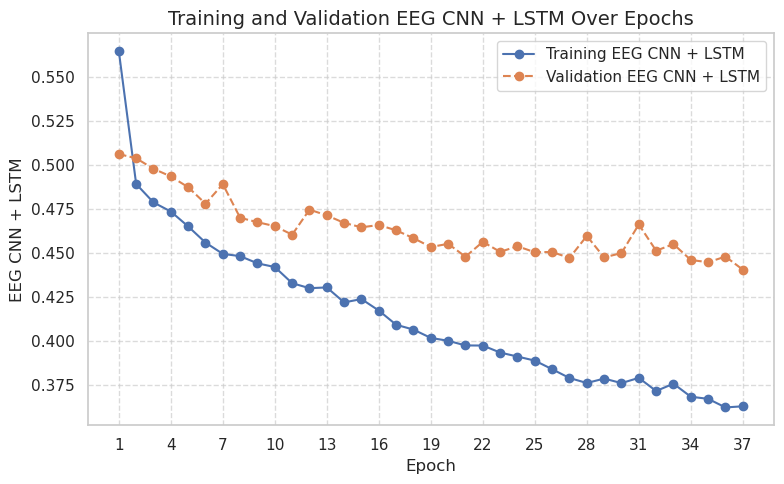

In [ ]:
plot_training_loss(train_history["loss"], val_history["loss"], "EEG CNN + LSTM")

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    cnn_lstm_model, test_loader, device,
    save_path=CNN_LSTM_SAVE_PATH,
    submission_path=CNN_LSTM_SUBMISSION_PATH
)

### 6. EEG CNN BiLSTM

In [ ]:
%aimport layers.cnn
from layers.cnn import EEG_CNN_LSTM

cnn_bi_lstm_model = EEG_CNN_LSTM(
    input_channels=19,
    cnn_output_channels=128,
    lstm_hidden_dim=128, 
    fc_dropout=0.3,
    lstm_dropout=0.3,
    num_classes=1,
    bidirectional_lstm=True
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    cnn_bi_lstm_model = nn.DataParallel(cnn_bi_lstm_model)
cnn_bi_lstm_model = cnn_bi_lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn_bi_lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=5,
    factor=0.5
)

In [ ]:
CNN_BI_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "cnn_bi_lstm_best_model.pt"
CNN_BI_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "cnn_bi_lstm_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
    cnn_bi_lstm_model, train_loader, val_loader,
    criterion, optimizer, device,
    save_path=CNN_BI_LSTM_SAVE_PATH,
    num_epochs=300,
    patience=30,
    monitor="val_loss",
    scheduler=scheduler,
    overwrite=True,
)

In [ ]:
plot_training_loss(train_history["loss"], val_history["loss"], "EEG CNN + BiLSTM")

In [ ]:
# evaluate model on test set and generate submission file
evaluate_model(
    cnn_bi_lstm_model, test_loader, device,
    save_path=CNN_BI_LSTM_SAVE_PATH,
    submission_path=CNN_BI_LSTM_SUBMISSION_PATH
)

## Graph methods

In [ ]:
from layers.eeggcn import EEGGCN

# Get number of time points (in_channels) from first sample
eeg_gnc_model = EEGGCN(
    in_channels=19,
    hidden_channels=128,
    out_channels=32,
    num_classes=2,
    num_conv_layers=3,
    dropout=0.5
)
if torch.cuda.device_count() > 1:
    eeg_gnc_model = nn.DataParallel(eeg_gnc_model)
eeg_gnc_model = eeg_gnc_model.to(device)

# Set up optimizer + scheduler
optimizer = optim.Adam(eeg_gnc_model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)
criterion = nn.BCEWithLogitsLoss()

EEGGCN_SAVE_PATH = CHECKPOINT_ROOT / "eeggcn_best_model.pt"
EEGCN_SUBMISSION_PATH = SUBMISSION_ROOT / "eeggcn_submission.csv"

# train model on training set (or load existing)
train_history, val_history = train_model(
    eeg_gnc_model, train_loader, val_loader,
    criterion, optimizer, device,
    save_path=EEGGCN_SAVE_PATH,
    num_epochs=300,
    patience=30,
    monitor="val_loss",
    scheduler=scheduler,
    overwrite=True,
)

# plot losses if any
plt.figure()
plt.plot(train_history["loss"], label="train")
plt.plot(val_history["loss"],   label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
evaluate_model(
    eeg_gnc_model, test_loader, device,
    save_path       = Path("eeggcn_attn.pt"),
    submission_path = Path("eeggcn_submission.csv"),
    threshold       = 0.5,
)